<a href="https://colab.research.google.com/github/TieuDiem/ResNet-CNN-Generalization/blob/main/ResNet34_ResNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet34 Skip Connection and No Skip Conenction

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D , AveragePooling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

In [ ]:
class RestNet34():
  def __init__(self,skip)->None:
    self.skip=skip
    return None  

  def identity_block(self,input,filter):
    x = layers.Conv2D(filters= filter,kernel_size=(3,3),padding="same",use_bias= False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu') (x)

    x = layers.Conv2D(filters= filter,kernel_size = (3,3),padding = "same",use_bias = False)(x)
    x = layers.BatchNormalization()(x)

    if self.skip == False:
      return layers.Activation('relu')(x)

    skip_connection = layers.add([input,x])

    x = layers.Activation('relu')(skip_connection)
    return x  

  def projection_block(self, input,filter,stride):
    x = layers.Conv2D(filters = filter , kernel_size = (3,3),
                      padding = "same",strides =stride,
                      use_bias = False)(input)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)  

    x = layers.Conv2D(filters=filter, kernel_size=(3,3), padding='same', 
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if self.skip ==False:
      return layers.Activation('relu')(x)


    short_cut = layers.Conv2D(filters = filter,
                              kernel_size=(1,1),
                              padding= "same",
                              use_bias= False,
                              strides = stride)(input)

    short_cut = layers.BatchNormalization()(short_cut)
    skip_connection = layers.add([short_cut,x])
    x  = layers.Activation('relu')(skip_connection)

    return x
    
  # Create block of ResNet34
  def __block1(self, input_shape ):
    input= tf.keras.Input(shape=input_shape)
    block_1 = layers.Conv2D(filters = 64,kernel_size  = (7,7),
                            strides =(2,2),padding  = "same",
                            use_bias = False)(input)
    block_1 = layers.BatchNormalization()(block_1)
    block_1 = layers.Activation('relu')(block_1)

    return input, block_1

  def __block2(self,input):
    block_2  =layers.MaxPooling2D(pool_size = (3,3),strides =2 ,padding="same")(input)
    
    block_2 = self.identity_block(input=block_2,filter =64)
    block_2 = self.identity_block(input=block_2,filter =64)
    block_2 = self.identity_block(input=block_2,filter =64)                            
    return block_2
  def __block3(self,input):

    block_3 =self.projection_block(input = input,filter=128,stride=2)
    block_3 =self.identity_block(input =block_3 ,filter =128 )
    block_3 =self.identity_block(input =block_3 ,filter =128 )
    block_3 =self.identity_block(input =block_3 ,filter =128 )
    return block_3 

  def __block4(self,input):
    block_4 =self.projection_block(input = input, filter=256,stride = 2)
    
    block_4 = self.identity_block(input =block_4,filter = 256)
    block_4 = self.identity_block(input =block_4,filter = 256)
    block_4 = self.identity_block(input =block_4,filter = 256)
    block_4 = self.identity_block(input =block_4,filter = 256)
    block_4 = self.identity_block(input =block_4,filter = 256)

    return block_4 

  def __block5(self,input):
    block_5 =self.projection_block(input = input,filter = 512,stride = 2)
    block_5 = self.identity_block(input =block_5,filter = 512)
    block_5 = self.identity_block(input =block_5,filter = 512)

    return block_5 

  def __dense(self,input,classes):
    dense = layers.AveragePooling2D(pool_size=(7,7))(input)
    return layers.Dense(units = classes,activation ="softmax")(dense)
  
  def build_model(self,num_class, input_shape= (224,224,3)):
    input, block_1 = self.__block1(input_shape)

    block_2 =self.__block2(block_1)            
    block_3 =self.__block3(block_2)     
    block_4 =self.__block4(block_3)      
    block_5 =self.__block5(block_4)      

    output =self.__dense(block_5,num_class)

    return Model(inputs = input,outputs = output)  

In [ ]:
resnet34_model_skip_connection =RestNet34(skip=True).build_model(num_class =11)
resnet34_model_skip_connection.summary()

In [ ]:
resnet34_model =RestNet34(skip=False).build_model(num_class =11)
resnet34_model.summary()

# ResNet121 Skip Connection and No Skip Connection

In [ ]:
class ResNet121():
  def __init__(self,skip):
    self.skip = skip

  # convolution block
  def conv_block (self,input,k=32):
    x = layers.BatchNormalization()(input)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters = 4*k , kernel_size = (1,1),use_bias = False)(x)

    x = layers.BatchNormalization()(input)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters = 4*k , kernel_size = (1,1),use_bias = False)(x)

    if self.skip == False:
      return x

    skip_connection = layers.Concatenate(axis=-1)([input,x])
    return skip_connection

  # dense block
  def dense_block(self, input,num_block,k=32):
    x = input
    for i in range(num_block):
      x = self.conv_block(x,32)
    return x

  # trasition block
  def trasition_block(self,input,fraction  = 0.5):
    channels= input.shape[-1]

    x = layers.BatchNormalization()(input)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=fraction* channels,kernel_size = (1,1),
                      use_bias =False)(x)

    x = layers.AveragePooling2D(pool_size = (2,2),strides =(2,2))(x)

    return  x  
  
  # build model
  def build_model(self,num_class):
    input  = tf.keras.Input(shape = (224,224,3))

    conv1  =layers.Conv2D(filters =64,kernel_size=(7,7),strides =2,use_bias =False,padding = "same")(input)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 =layers.Activation('relu')(conv1)
    
    pooling  = layers.MaxPooling2D(pool_size = (3,3),strides = 2,padding = 'same')(conv1)

    dl1 = self.dense_block(input =pooling, num_block =6)
    dl1 = self.trasition_block(input =dl1)

    dl2 = self.dense_block(input =dl1, num_block =12)
    dl2 = self.trasition_block(input =dl2)

    dl3 = self.dense_block(input =dl2, num_block =24)
    dl3 = self.trasition_block(input =dl3)

    dl4= self.dense_block(input =dl3, num_block =16)

    ave =layers.AveragePooling2D(pool_size =(7,7),padding = 'same')(dl4)
    dense = layers.Dense(units =  num_class ,activation =  'softmax')(ave)

    return Model(inputs = input,outputs =dense ) 

In [ ]:
resNet121_model_skip_connection =ResNet121(skip=True).build_model(num_class =1000)
resNet121_model_skip_connection.summary()

In [ ]:
resNet121_model =ResNet121(skip=False).build_model(num_class =1000)
resNet121_model.summary()

# Data Processing

## Dowload Data

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F
To: /content/weather-dataset.zip
100% 613M/613M [00:09<00:00, 66.0MB/s]


In [ ]:
!unzip weather-dataset.zip

## Visualization Data

In [ ]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
WEATHER_DATA_PATH = '/content/weather-dataset/dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/weather-dataset/dataset/rime/5917.jpg,rime
1,/content/weather-dataset/dataset/hail/0168.jpg,hail
2,/content/weather-dataset/dataset/sandstorm/330...,sandstorm
3,/content/weather-dataset/dataset/dew/2349.jpg,dew
4,/content/weather-dataset/dataset/lightning/186...,lightning


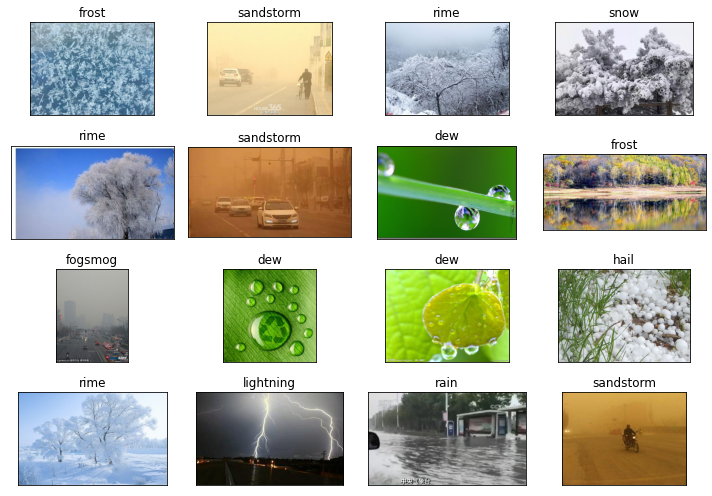

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

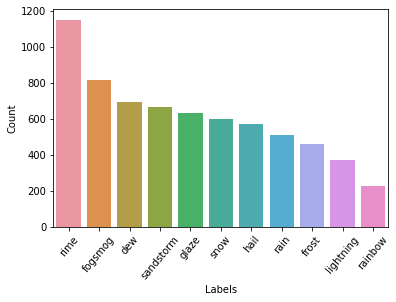

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

## Data Generation

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds =tf.keras.utils.image_dataset_from_directory(
    directory  = WEATHER_DATA_PATH,
    validation_split  =0.2,
    subset ="training",
    seed =123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


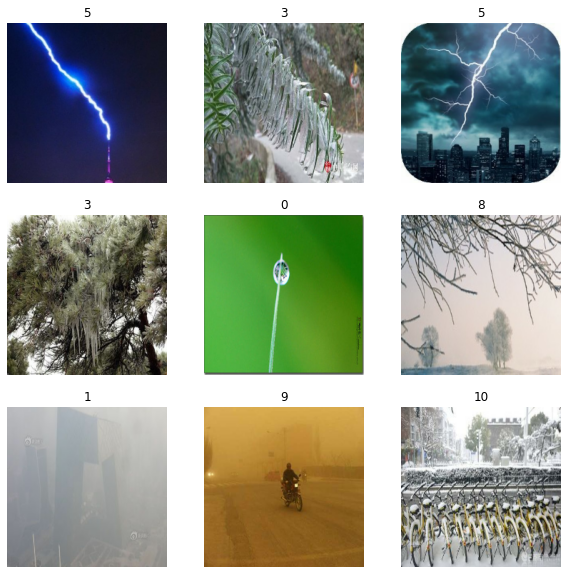

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), 
                           width_factor=(-0.1, 0.1), 
                           fill_mode='nearest')
])

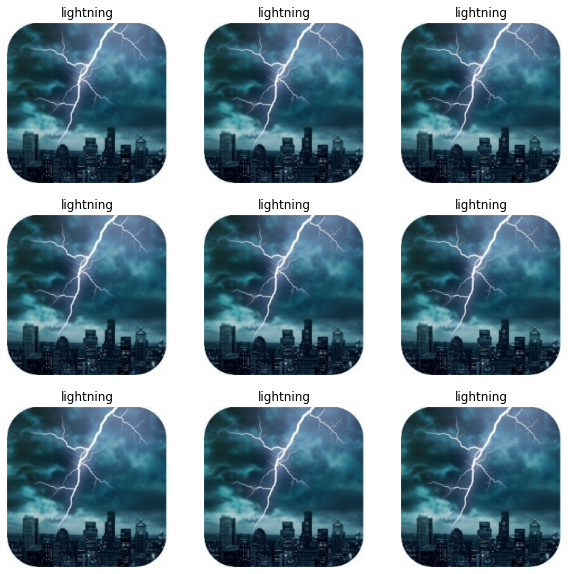

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

# Training 

In [ ]:
resnet34_model_skip_connection =RestNet34(skip=True).build_model(num_class =11)
resnet34_model_skip_connection.summary()

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = resnet34_model_skip_connection(x)
weather_resnet34_model_skip = Model(inputs=image_input, outputs=x)

weather_resnet34_model_skip.summary()

In [ ]:
num_epochs= 50 

weather_resnet34_model_skip.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = weather_resnet34_model_skip.fit(train_ds,
                                epochs = num_epochs,
                                batch_size  =32,
                                verbose  = 1,
                                  = val_ds)

Epoch 1/50


172/172 [==============================] - 74s 395ms/step - loss: 1.2374 - accuracy: 0.1186 - val_loss: 3.6404 - val_accuracy: 0.0996
Epoch 2/50
172/172 [==============================] - 69s 399ms/step - loss: 1.1162 - accuracy: 0.1195 - val_loss: 1.3629 - val_accuracy: 0.1141
Epoch 3/50
172/172 [==============================] - 68s 391ms/step - loss: 1.0513 - accuracy: 0.1183 - val_loss: 1.2046 - val_accuracy: 0.1330
Epoch 4/50
172/172 [==============================] - 68s 392ms/step - loss: 1.0141 - accuracy: 0.1177 - val_loss: 1.1667 - val_accuracy: 0.1192
Epoch 5/50
172/172 [==============================] - 68s 391ms/step - loss: 0.9801 - accuracy: 0.1182 - val_loss: 1.1018 - val_accuracy: 0.1263
Epoch 6/50
172/172 [==============================] - 68s 392ms/step - loss: 0.9516 - accuracy: 0.1179 - val_loss: 0.9913 - val_accuracy: 0.1255
Epoch 7/50
172/172 [==============================] - 68s 390ms/step - loss: 0.9240 - accuracy: 0.1187 - val_loss: 1.0903 - val_accuracy: 0.1

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error resnet34_model_noskip')
plt.legend()
plt.grid(True)